<a href="https://colab.research.google.com/github/AminPA/Matlab2020-10/blob/main/LevelSetLatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lsml
!pip install SimpleITK
!pip install pydicom

     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 419kB 6.6MB/s 
  Created wheel for scikit-fmm: filename=scikit_fmm-2021.2.2-cp37-cp37m-linux_x86_64.whl size=196590 sha256=9626d582664d8f945a99d41be36b7638f5a518f31998a895358e743a203530c0
  Stored in directory: /root/.cache/pip/wheels/86/5e/cb/4acf0bc71b46618ab7761d4b603227f29e56a3ec4ff2f64844
Successfully built scikit-fmm
     |████████████████████████████████| 47.4MB 88kB/s 
     |████████████████████████████████| 1.9MB 5.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import SimpleITK
import glob, os
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from lsml.data.dim2 import hamburger
from lsml import LevelSetMachineLearning
from lsml.feature import get_basic_image_features, get_basic_shape_features
from lsml.initializer import RandomBallInitializer
import skfmm
from lsml.core.datasets_handler import DatasetsHandler

In [4]:
##visualizing image with sitk

In [5]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    # spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    # extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
 
    plt.set_cmap("gray")
    ax.imshow(nda, extent=extent, interpolation=None)
 
    if title:
        plt.title(title)
 
    plt.show()

In [19]:
def Load_my_data():

  n_samples = 15
  DATADIR_img = '/content/gdrive/MyDrive/Pittsbergh/TestPatientsForAmin/Patient11/ems11diastole/Images/'
  DATADIR_seg = '/content/gdrive/MyDrive/TestPatientsForAmin/Patient11/ems11diastole/Segmnetations.mha'
  # imgs = np.zeros((16,256,256))
  #To read all the photos
  img_list1,seg_list,img_list = [],[],[]
  i_list = []
  

  #Read Images
  
  # i = 0
  for file in glob.glob("/content/gdrive/MyDrive/TestPatientsForAmin/Patient11/ems11diastole/Images/*.IMA"):
  # imgs[i,:,:] = pydicom.read_file(file).pixel_array
  # i+=1
    img_list1.append(pydicom.read_file(file).pixel_array)


    

  

  #Read Segmentations
  segs_sitk = SimpleITK.ReadImage(DATADIR_seg)
  segs_array = SimpleITK.GetArrayFromImage(segs_sitk)

  #visualize two sample segmentations and remove the images that do not have segmentation
  # Slice index to visualize with 'sitk_show'
  idxSlice = 1
  for i in range (segs_array.shape[0]):
    if np.all(segs_array[i,:,:] == 0):
      print("no seg")

    else:  
      img_list.append(img_list1[i][102:154,102:154])
      seg_list.append(segs_array[i,102:154,102:154])
      sitk_show(SimpleITK.Tile(segs_sitk[102:154,102:154, i],
                                  (2, 1, 0)))

  segs_array = np.array(seg_list)
  imgs_array = np.array(img_list)
  
  imgs = imgs_array.astype(float)
  segs = segs_array.astype(bool)
  imgs = np.repeat(imgs,14, axis=0)
  segs = np.repeat(segs,14, axis=0)
  print(imgs.shape,segs.shape)

  return imgs,segs



#original code from 
https://github.com/notmatthancock/level-set-machine-learning/blob/master/examples/hamburger2d/main.py

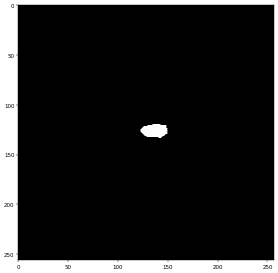

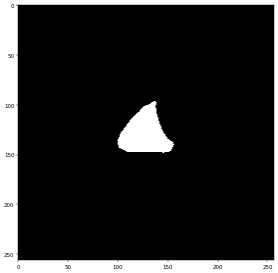

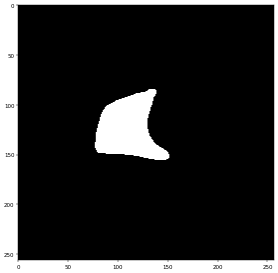

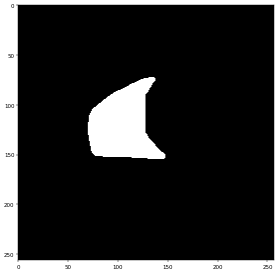

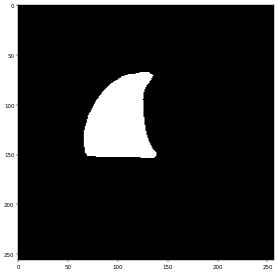

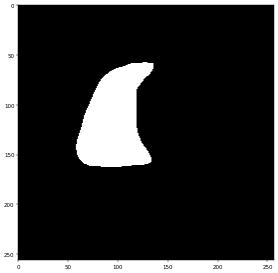

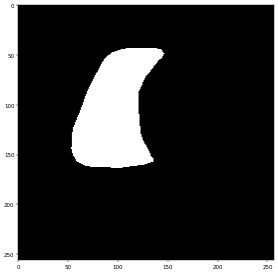

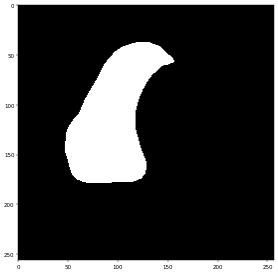

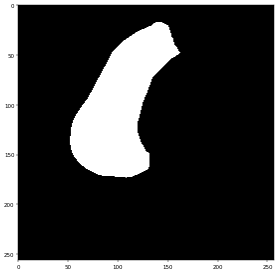

In [20]:
!rm -r "/content/tmp"
!rm "/content/LSML-model.pkl"
!rm "/content/dataset.h5"
#original 
random_state = np.random.RandomState(1234)


# Create a toy dataset ########################################################

# n_samples = 200
# imgs, segs = hamburger.make_dataset(
#     N=n_samples, random_state=random_state)

#My data
my_imgs ,my_segs = Load_my_data()

# Set up the model and fit it #################################################

lsml = LevelSetMachineLearning(
    features=get_basic_image_features() + get_basic_shape_features(),
    initializer=RandomBallInitializer(random_state=random_state)
)

lsml.fit(
    'dataset.h5', imgs=my_imgs, segs=my_segs,
    max_iters=10, random_state=random_state,

    # We use a sklearn Pipeline as the regression model which is
    # simply a standard scaler followed by linear regression
    regression_model_class=Pipeline,
    regression_model_kwargs=dict(
        steps=[
            ('standardscaler', StandardScaler()),
            ('linearregressor', LinearRegression()),
        ],
     )
)

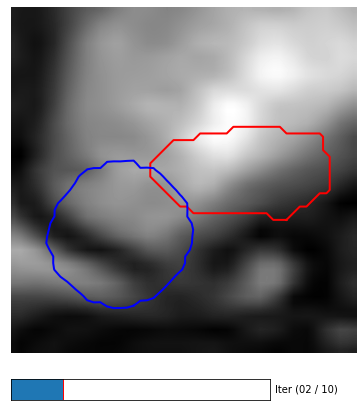

In [21]:
from lsml import LevelSetMachineLearning
from lsml.visualize import interactive2d
#os.chdir("./content/")

# Load the model and grab an example from the testing set
model = LevelSetMachineLearning.load('./LSML-model.pkl')
example = model.testing_data[0]

# Segment the example image
us = model.segment(img=example.img)

# View the example interactively
interactive2d(u=us, img=example.img, seg=example.seg)